### IMPORTING LIBRARIES

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    precision_recall_curve
)

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

print("Libraries imported successfully.")


Libraries imported successfully.


### DATASET PREPARATION

In [2]:
# Load the dataset
try:
    df = pd.read_csv('preprocessed_dataset/preprocessed_data.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError("CSV not found. Place it in 'preprocessed_dataset/' or adjust the path.")

Dataset loaded successfully.


In [3]:
print("Shape:", df.shape)
display(df.head())

Shape: (7043, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.277445,-1.160323,-0.994242,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,0.066327,-0.259629,-0.173244,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,-1.236724,-0.362660,-0.959674,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,0.514251,-0.746535,-0.194766,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,-1.236724,0.197365,-0.940470,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [4]:
# Separate features (X) and target (y)
if "Churn" not in df.columns:
    raise KeyError("Column 'Churn' not found in preprocessed data. "
                   "Ensure Task 1 saved the target as 'Churn'.")

X = df.drop("Churn", axis=1)
y = df["Churn"]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)


Feature matrix shape: (7043, 30)
Target vector shape: (7043,)


In [5]:
# Quick class balance check
print("\nClass distribution (Churn):")
print(y.value_counts())
print("\nClass distribution (%):")
print((y.value_counts(normalize=True) * 100).round(2))


Class distribution (Churn):
Churn
0    5174
1    1869
Name: count, dtype: int64

Class distribution (%):
Churn
0    73.46
1    26.54
Name: proportion, dtype: float64


### TRAIN–TEST SPLIT

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (5634, 30)
Test set shape: (1409, 30)


### EVALUATION FUNCTION

In [7]:
def evaluate_classifier(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Fit the model (assumed already tuned), predict on train and test,
    and print common classification metrics.
    """
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probabilities for ROC-AUC (if available)
    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        # Fallback using decision_function if predict_proba is unavailable
        y_test_proba = model.decision_function(X_test)
    
    metrics = {}
    
    for split, y_true, y_hat in [
        ("Train", y_train, y_train_pred),
        ("Test",  y_test,  y_test_pred)
    ]:
        acc  = accuracy_score(y_true, y_hat)
        prec = precision_score(y_true, y_hat, zero_division=0)
        rec  = recall_score(y_true, y_hat, zero_division=0)
        f1   = f1_score(y_true, y_hat, zero_division=0)
        
        if split == "Test":
            auc = roc_auc_score(y_true, y_test_proba)
        else:
            auc = np.nan  # just to keep structure
        
        metrics[f"{split}_accuracy"]  = acc
        metrics[f"{split}_precision"] = prec
        metrics[f"{split}_recall"]    = rec
        metrics[f"{split}_f1"]        = f1
        if split == "Test":
            metrics[f"{split}_roc_auc"] = auc
        
        print(f"\n{model_name} – {split} metrics")
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1 score : {f1:.4f}")
        if split == "Test":
            print(f"ROC-AUC  : {auc:.4f}")
    
    # Confusion matrix (test set)
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} – Confusion Matrix (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print(f"\nClassification report – {model_name} (Test set):")
    print(classification_report(y_test, y_test_pred, digits=4))
    
    return metrics, y_test_proba


### DECISION TREE CLASSIFIER (WITH HYPERPARAMETER TUNING)

In [8]:
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

param_grid_dt = {
    "max_depth": [3, 5, 8, None],
    "min_samples_split": [2, 10, 25],
    "min_samples_leaf": [1, 5, 10],
    "criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

print("Best Decision Tree parameters:")
print(grid_dt.best_params_)
print(f"Best CV ROC-AUC: {grid_dt.best_score_:.4f}")


Best Decision Tree parameters:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 25}
Best CV ROC-AUC: 0.8258



Decision Tree – Train metrics
Accuracy : 0.7393
Precision: 0.5054
Recall   : 0.8114
F1 score : 0.6228

Decision Tree – Test metrics
Accuracy : 0.7239
Precision: 0.4874
Recall   : 0.7754
F1 score : 0.5986
ROC-AUC  : 0.8273


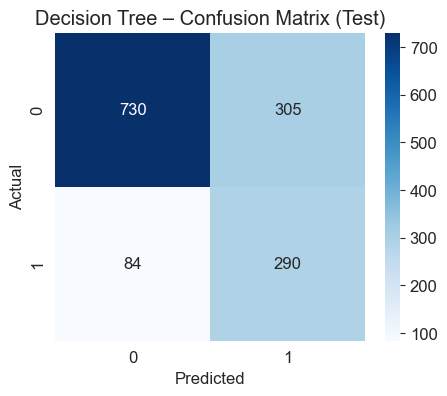


Classification report – Decision Tree (Test set):
              precision    recall  f1-score   support

           0     0.8968    0.7053    0.7896      1035
           1     0.4874    0.7754    0.5986       374

    accuracy                         0.7239      1409
   macro avg     0.6921    0.7404    0.6941      1409
weighted avg     0.7881    0.7239    0.7389      1409



In [9]:
# ----- Decision Tree: Confusion Matrix -----
best_dt = grid_dt.best_estimator_

dt_metrics, dt_test_proba = evaluate_classifier(
    best_dt,
    X_train, X_test,
    y_train, y_test,
    model_name="Decision Tree"
)


<Figure size 700x500 with 0 Axes>

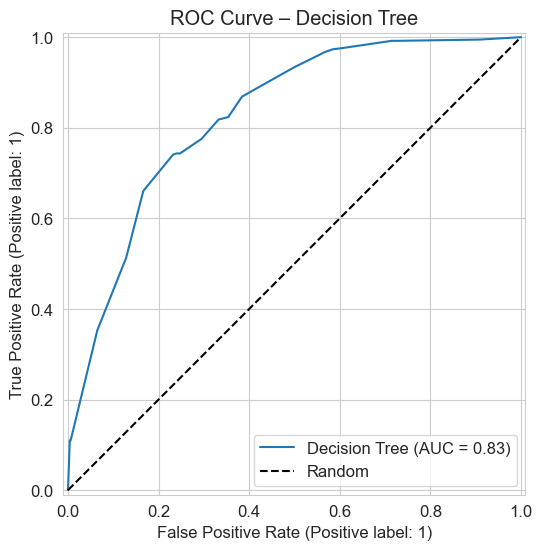

In [10]:
# ----- Decision Tree: ROC curve -----
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

plt.figure(figsize=(7, 5))
RocCurveDisplay.from_predictions(
    y_test,
    y_proba_dt,
    name="Decision Tree",
    color="tab:blue"
)
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curve – Decision Tree")
plt.legend()
plt.show()

### NEURAL NETWORK CLASSIFIER (MLP) WITH HYPERPARAMETER TUNING

In [11]:
mlp = MLPClassifier(
    max_iter=400,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=15
)

param_grid_mlp = {
    "hidden_layer_sizes": [(32,), (64,), (32, 16)],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate_init": [0.001, 0.01]
}

grid_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_mlp.fit(X_train, y_train)

print("Best MLP parameters:")
print(grid_mlp.best_params_)
print(f"Best CV ROC-AUC: {grid_mlp.best_score_:.4f}")


Best MLP parameters:
{'alpha': 0.0001, 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.01}
Best CV ROC-AUC: 0.8428



Neural Network (MLP) – Train metrics
Accuracy : 0.8145
Precision: 0.6872
Recall   : 0.5525
F1 score : 0.6125

Neural Network (MLP) – Test metrics
Accuracy : 0.7949
Precision: 0.6375
Recall   : 0.5267
F1 score : 0.5769
ROC-AUC  : 0.8402


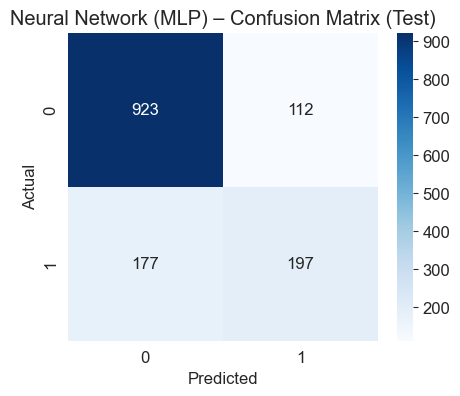


Classification report – Neural Network (MLP) (Test set):
              precision    recall  f1-score   support

           0     0.8391    0.8918    0.8646      1035
           1     0.6375    0.5267    0.5769       374

    accuracy                         0.7949      1409
   macro avg     0.7383    0.7093    0.7208      1409
weighted avg     0.7856    0.7949    0.7883      1409



In [12]:
# ----- Neural Network (MLP): Confusion Matrix -----
best_mlp = grid_mlp.best_estimator_

mlp_metrics, mlp_test_proba = evaluate_classifier(
    best_mlp,
    X_train, X_test,
    y_train, y_test,
    model_name="Neural Network (MLP)"
)


<Figure size 700x500 with 0 Axes>

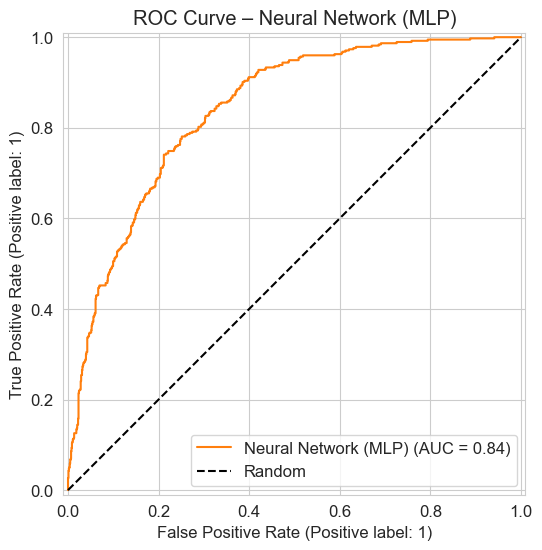

In [13]:
# ----- Neural Network (MLP): ROC curve -----
y_proba_mlp = best_mlp.predict_proba(X_test)[:, 1]

plt.figure(figsize=(7, 5))
RocCurveDisplay.from_predictions(
    y_test,
    y_proba_mlp,
    name="Neural Network (MLP)",
    color="tab:orange"
)
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curve – Neural Network (MLP)")
plt.legend()
plt.show()

### MODEL EVALUATION & COMPARISON

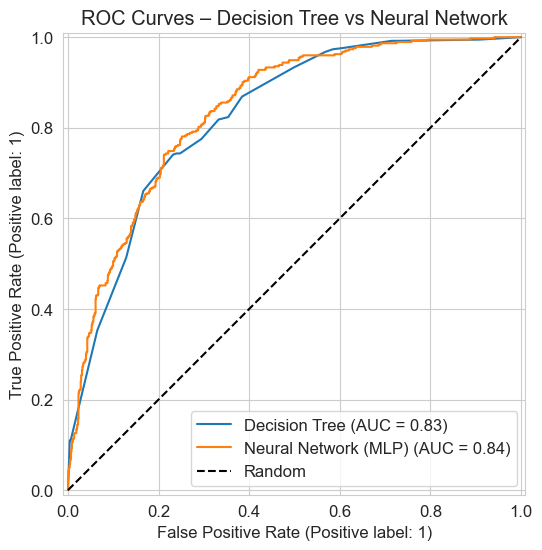

In [14]:
plt.figure(figsize=(8, 6))

RocCurveDisplay.from_estimator(
    best_dt, X_test, y_test,
    name="Decision Tree",
    ax=plt.gca()
)

RocCurveDisplay.from_estimator(
    best_mlp, X_test, y_test,
    name="Neural Network (MLP)",
    ax=plt.gca()
)

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curves – Decision Tree vs Neural Network")
plt.legend()
plt.show()


In [15]:
# Metrics Comparison Table
comparison_df = pd.DataFrame({
    "Model": ["Decision Tree", "Neural Network (MLP)"],
    "Test Accuracy": [dt_metrics["Test_accuracy"], mlp_metrics["Test_accuracy"]],
    "Test Precision": [dt_metrics["Test_precision"], mlp_metrics["Test_precision"]],
    "Test Recall": [dt_metrics["Test_recall"], mlp_metrics["Test_recall"]],
    "Test F1": [dt_metrics["Test_f1"], mlp_metrics["Test_f1"]],
    "Test ROC-AUC": [dt_metrics["Test_roc_auc"], mlp_metrics["Test_roc_auc"]],
})

display(comparison_df.round(4))


,Model,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC-AUC
0,Decision Tree,0.7239,0.4874,0.7754,0.5986,0.8273
1,Neural Network (MLP),0.7949,0.6375,0.5267,0.5769,0.8402


Best model based on Test ROC-AUC: Neural Network (MLP)

Best threshold for F1 (on test set): 0.311
Precision at best threshold: 0.5585
Recall at best threshold   : 0.7406
F1 score at best threshold : 0.6368


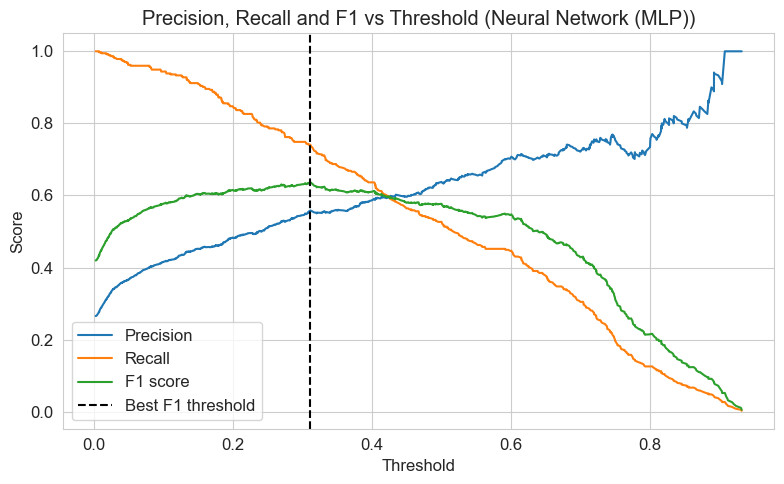


Confusion matrix at optimised threshold (Neural Network (MLP)):


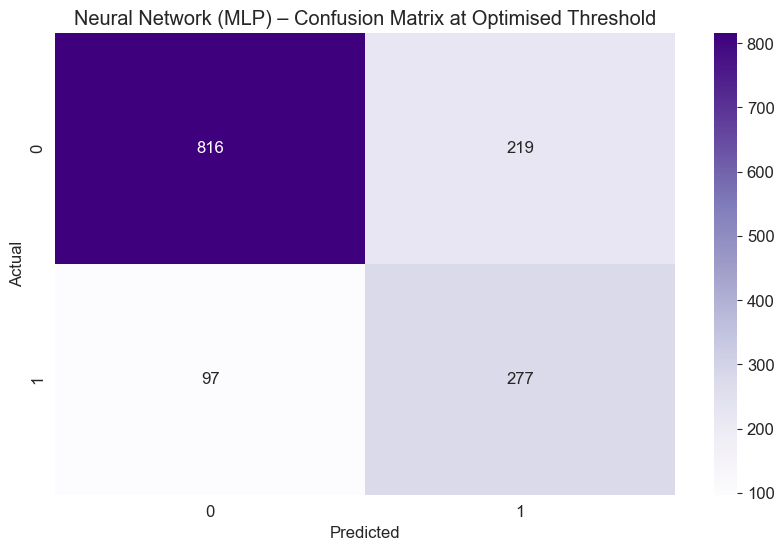


Classification report at optimised threshold:
              precision    recall  f1-score   support

           0     0.8938    0.7884    0.8378      1035
           1     0.5585    0.7406    0.6368       374

    accuracy                         0.7757      1409
   macro avg     0.7261    0.7645    0.7373      1409
weighted avg     0.8048    0.7757    0.7844      1409



In [16]:
# Identify the best model based on Test ROC-AUC
best_idx = comparison_df["Test ROC-AUC"].idxmax()
best_model_name = comparison_df.loc[best_idx, "Model"]

print(f"Best model based on Test ROC-AUC: {best_model_name}")

if best_model_name == "Decision Tree":
    y_scores = dt_test_proba
elif best_model_name == "Neural Network (MLP)":
    y_scores = mlp_test_proba
else:
    raise ValueError("Unexpected model name in comparison_df.")

# Compute precision–recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Compute F1 for each threshold (ignore the last precision/recall point with no threshold)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-8)
best_thresh_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_thresh_idx]

print(f"\nBest threshold for F1 (on test set): {best_threshold:.3f}")
print(f"Precision at best threshold: {precisions[best_thresh_idx]:.4f}")
print(f"Recall at best threshold   : {recalls[best_thresh_idx]:.4f}")
print(f"F1 score at best threshold : {f1_scores[best_thresh_idx]:.4f}")

# Plot Precision-Recall vs threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1_scores, label="F1 score")
plt.axvline(best_threshold, color="k", linestyle="--", label="Best F1 threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title(f"Precision, Recall and F1 vs Threshold ({best_model_name})")
plt.legend()
plt.tight_layout()
plt.show()

# Build hard predictions using the optimised threshold
y_pred_opt = (y_scores >= best_threshold).astype(int)

print(f"\nConfusion matrix at optimised threshold ({best_model_name}):")
cm_opt = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Purples")
plt.title(f"{best_model_name} – Confusion Matrix at Optimised Threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification report at optimised threshold:")
print(classification_report(y_test, y_pred_opt, digits=4))


### FEATURE IMPORTANCE – DECISION TREE

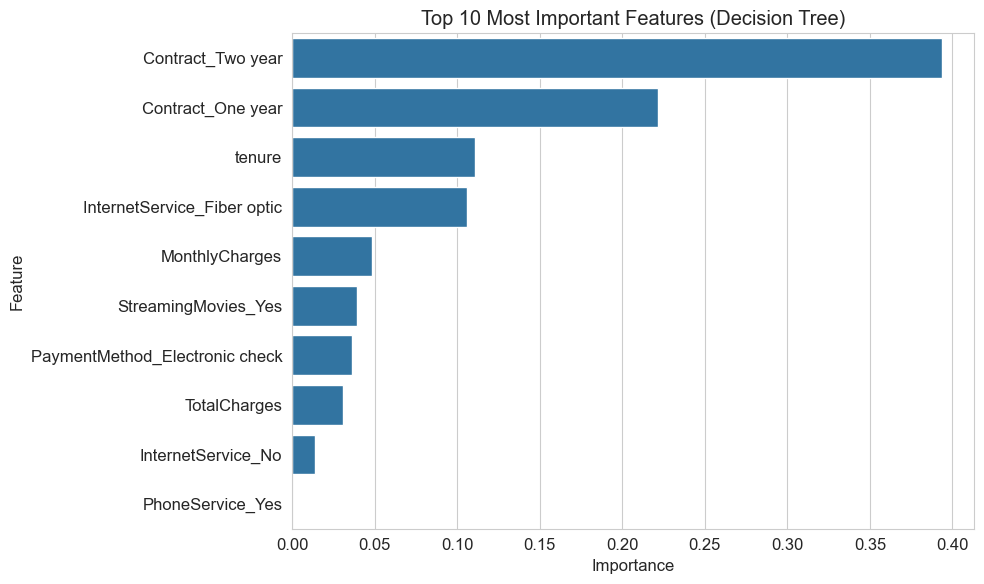

Contract_Two year                 0.3934
Contract_One year                 0.2214
tenure                            0.1106
InternetService_Fiber optic       0.1058
MonthlyCharges                    0.0482
StreamingMovies_Yes               0.0393
PaymentMethod_Electronic check    0.0364
TotalCharges                      0.0310
InternetService_No                0.0139
PhoneService_Yes                  0.0000
dtype: float64

In [17]:
# Top 10 Important Features
feature_importances = pd.Series(
    best_dt.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(
    x=feature_importances.head(top_n),
    y=feature_importances.head(top_n).index,
    orient="h"
)
plt.title(f"Top {top_n} Most Important Features (Decision Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

display(feature_importances.head(top_n).round(4))
